In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

In [3]:
import numpy
def plot_synthetic_data_trial(ax, data, trial, title=None, xylabs=None, color='tab:blue'):
    title_size = 12
    label_size = 10
    x = jnp.arange(0, 1000) / 1000
    # for i in range(start,start+3):
    l = trial
    K = data.shape[1]
    # i = 3
        
    for k in range(K):
        if type(color) is str:
            ax.plot(x, data[:,k,l], color=color)
        elif type(color) is numpy.ndarray:
            ax.plot(x, data[:,k,l], color=color[k])
        else:
            raise ValueError
    if title is None:
        ax.set_title(f'Trial {trial}', size=title_size)
    ax.margins(0)

    if xylabs is None:
        ax.set_ylabel('Intensity', size = label_size)
        ax.set_xlabel('Time (sec)', size = label_size)
    elif len(xylabs) == 2:
        ax.set_xlabel(xylabs[0], size = label_size)
        ax.set_ylabel(xylabs[1], size = label_size)
    else:
        raise ValueError
    # plt.xlim([0,sample_length/fs])


In [4]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

In [5]:
# num_iters = 50

# # 100000 10000000 1000000000
# scale_init = 10000000
# lcfg_attrs = {}

# mcfg_attrs = {'emiters': num_iters}

# ocfg_attrs = {'obs_type': 'pp_relu'}

# res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/batch/outputs/2024-11-24',
#              '/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/batch/outputs/2024-11-22-temp']
# # for res_path in res_paths:
# #     clean_dir(res_path)

# res_load_refac = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
# Ls = sorted([r['cfg'].latent.L for r in res_load_refac])
# alphas = sorted([r['cfg'].obs.alpha for r in res_load_refac])

# alpha = 50
# osel = {'alpha': alpha}
# res_jax_refac = filter_loaded(res_load_refac, {}, {}, osel)
# cfg = res_jax_refac[0]['cfg']

In [6]:
from cohlib.jax.dists import sample_from_gamma, sample_obs
from cohlib.jax.observations import add0


In [7]:
def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

In [21]:
from cohlib.jax.dists import sample_ccn_rank1
N = 500
nz = jnp.array([9])
nz_model = nz
L = 25
seed = 7
latent_seed = seed


K = 3
# TODO 
J = 1
scale_target = 1e3
scale_gamma = 1e0
target_freq_ind = 9

phases = jr.uniform(jr.key(latent_seed), (K,), minval=-jnp.pi, maxval=jnp.pi)
reals = jnp.cos(phases)
imags = jnp.sin(phases)

eigvec_target = reals + 1j*imags
eigvec_target = eigvec_target / jnp.linalg.norm(eigvec_target)
eigvec_target = eigvec_target*jnp.exp(-1j*jnp.angle(eigvec_target[0]))
eigval_target = K*scale_target*scale_gamma
# eigval_target = (150)*scale_target*scale_gamma


lrk = jr.key(seed)
zs_target = sample_ccn_rank1(lrk, eigvec_target, eigval_target, K, L)



gamma = jnp.zeros((N,K,K), dtype=complex)
zs = sample_from_gamma(lrk, gamma, L)
zs = zs.at[target_freq_ind,:,:].set(zs_target)

gamma_target = eigval_target * jnp.einsum('i,j->ij', eigvec_target, eigvec_target.conj()) 
real_diag = jnp.diag(gamma_target).real
gamma_target = gamma_target.at[jnp.eye(K).astype(bool)].set(real_diag)

gamma = gamma.at[target_freq_ind,:,:].set(gamma_target)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

obs_type = 'gaussian'
ov1 = 5
ov2 = -1
obs_params = {'seed': seed, 'obs_type': obs_type, 'ov1': ov1, 'ov2': ov2}

obs = sample_obs(xs, obs_params)

Sampling Gaussian observations with variance 5e^-1


In [12]:
eigvec_target[None,:,None]

Array([[[0.57735026+3.1732554e-09j],
        [0.17434959+5.5039579e-01j],
        [0.07730767+5.7215106e-01j]]], dtype=complex64)

In [13]:
_, ev1 = jnp.linalg.eigh(gamma_target.squeeze())
ev1[:,-1]

Array([0.5773503 +0.j        , 0.1743496 +0.5503958j ,
       0.07730764+0.57215106j], dtype=complex64)

In [14]:
jnp.array([eigval_target])[None,:].shape

(1, 1)

In [15]:
from cohlib.jax.dists import naive_estimator
gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz,:,:], zs[nz,:,:].conj()).mean(-1)
naive_est = naive_estimator(obs, nz_model) 

In [16]:
k = 3
print(naive_est[:,k,k].real)
print(gamma[9,k,k])
print(gamma_oracle[:,k,k].real)

[1187.9473]
(999.99994+0j)
[844.2138]


In [17]:
obs.mean()

Array(-0.00200626, dtype=float32)

Text(0.5, 1.0, 'xs')

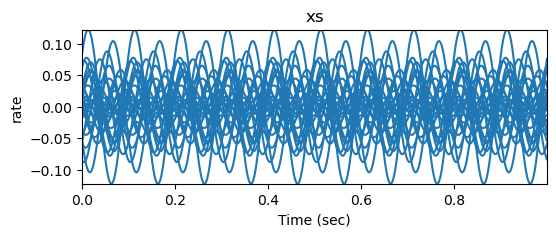

In [18]:
Ks_plot = jnp.array([0])
xs_plot= xs[:,Ks_plot,:]
# obs_plot = obs[:,Ks_plot,:]

fig,ax = plt.subplots(figsize=(6,2))
for trial in range(L):
    plot_synthetic_data_trial(ax, xs_plot, trial, 
     xylabs=['Time (sec)', 'rate'])
# ax.set_ylim([0,200])
# ax.set_title(r'obs var=' f'{ocfg.ov1}e{ocfg.ov2}; ' + '$x^{0,\ell}$')
ax.set_title(f'xs')

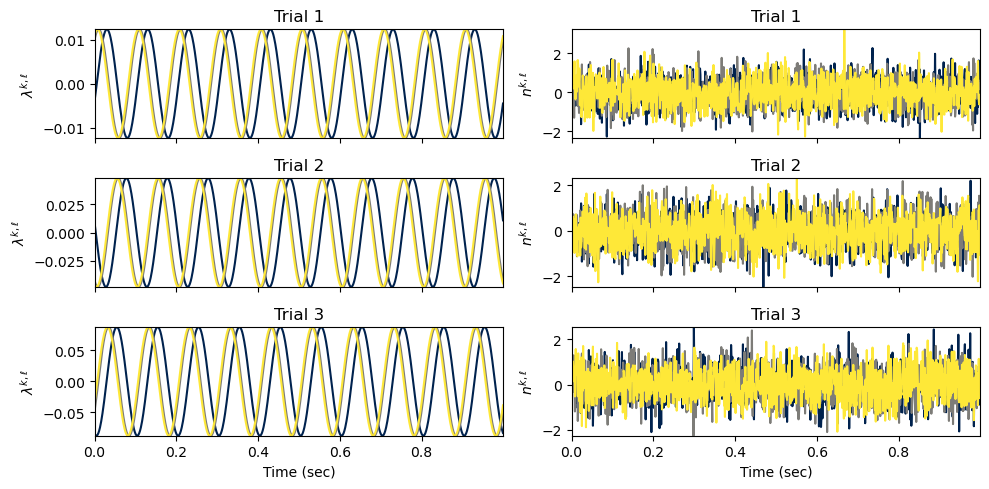

In [19]:
# Ks_plot = jnp.array([0,5,10,15])
fig,ax = plt.subplots(3,2,figsize=(10,5), sharex=True)
trials = jnp.arange(3)+1

colors = plt.cm.cividis(jnp.linspace(0,1,K))
for i, trial in enumerate(trials):
    if trial == trials[-1]:
        xlab='Time (sec)'
    else:
        xlab=''

    plot_synthetic_data_trial(ax[i,0], xs, trial, color=colors, xylabs=[xlab, '$\\lambda^{k,\ell}$'])
    # ax[i,0].set_ylim([0,50])
    plot_synthetic_data_trial(ax[i,1], obs, trial, color=colors, xylabs=[xlab, '$n^{k,\ell}$'])
plt.tight_layout()
plt.show()


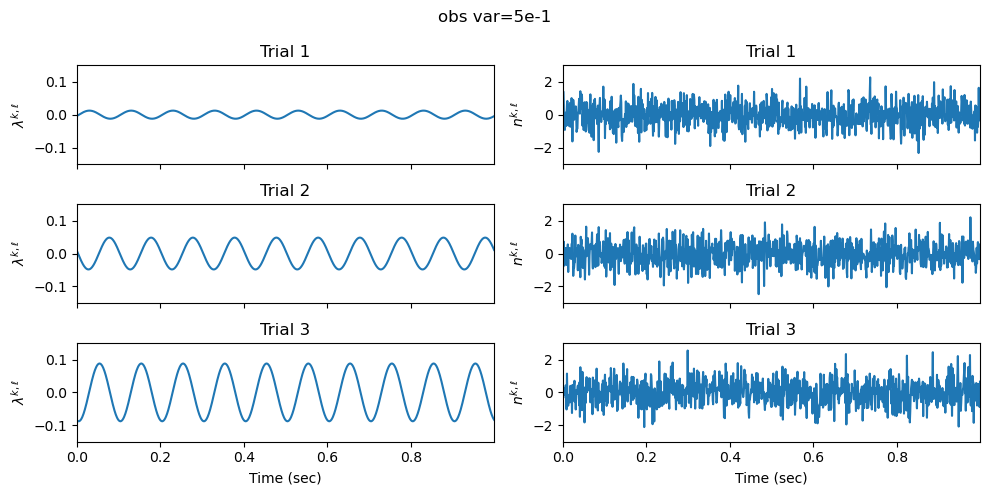

In [22]:
# Ks_plot = jnp.array([0,5,10,15])
fig,ax = plt.subplots(3,2,figsize=(10,5), sharex=True)
trials = jnp.arange(3)+1

K_plot = jnp.array([0])
xs_plot = xs[:,K_plot,:]
obs_plot = obs[:,K_plot,:]

colors = plt.cm.cividis(jnp.linspace(0,1,K))
for i, trial in enumerate(trials):
    if trial == trials[-1]:
        xlab='Time (sec)'
    else:
        xlab=''

    plot_synthetic_data_trial(ax[i,0], xs_plot, trial, xylabs=[xlab, '$\\lambda^{k,\ell}$'])
    plot_synthetic_data_trial(ax[i,1], obs_plot, trial, xylabs=[xlab, '$n^{k,\ell}$'])
    ax[i,0].set_ylim([-0.15, 0.15])
    ax[i,1].set_ylim([-3, 3])
fig.suptitle(r'obs var=' f'{ov1}e{ov2}')
plt.tight_layout()
plt.show()


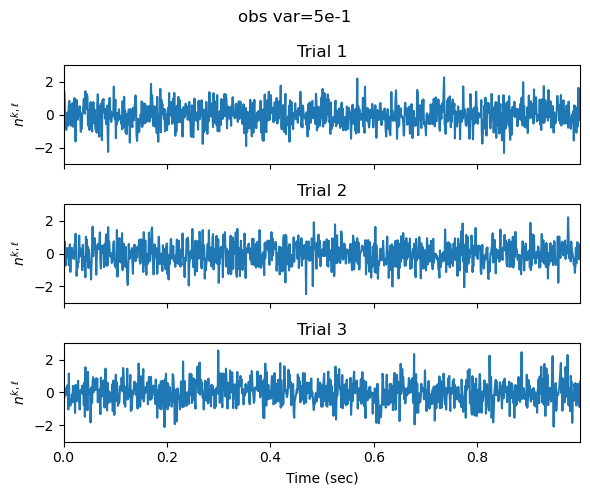

In [23]:
# Ks_plot = jnp.array([0,5,10,15])
fig,ax = plt.subplots(3,1,figsize=(6,5), sharex=True)
trials = jnp.arange(3)+1

K_plot = jnp.array([0])
xs_plot = xs[:,K_plot,:]
obs_plot = obs[:,K_plot,:]

colors = plt.cm.cividis(jnp.linspace(0,1,K))
for i, trial in enumerate(trials):
    if trial == trials[-1]:
        xlab='Time (sec)'
    else:
        xlab=''

    plot_synthetic_data_trial(ax[i], obs_plot, trial, xylabs=[xlab, '$n^{k,\ell}$'])
    # ax[i].set_ylim([-0.15, 0.15])
    ax[i].set_ylim([-3, 3])
fig.suptitle(r'obs var=' f'{ov1}e{ov2}')
plt.tight_layout()
plt.show()


In [24]:
from cohlib.utils import pickle_save, gamma_root
freqs = jnp.arange(500)
nonzero_inds = nz 
target_inds = jnp.array([target_freq_ind])
save_path = os.path.join(gamma_root(), f'k{K}-chlg3-gaussian-rank1-nz9.pkl')
save_dict = {'gamma': gamma, 'freqs': freqs, 'nonzero_inds': nonzero_inds, 
             'target_inds': target_inds, 'eigvec': eigvec_target, 'eigval': eigval_target}
# pickle_save(save_dict, save_path)

In [25]:
evals, evecs = jnp.linalg.eigh(gamma[9,:,:])

In [26]:
rank = 2
temp_evals = evals[::-1].at[rank:].set(0)[::-1]

In [27]:
evecs @ jnp.diag(temp_evals) @ evecs.conj().T

Array([[1000.0001 +0.0000000e+00j,  301.98233-9.5331348e+02j,
         133.90079-9.9099463e+02j],
       [ 301.98233+9.5331348e+02j,  999.9999 +0.0000000e+00j,
         985.16425-1.7161356e+02j],
       [ 133.9008 +9.9099463e+02j,  985.1642 +1.7161356e+02j,
         999.99994-1.5258789e-05j]], dtype=complex64)

In [28]:
temp_evals

Array([0.0000000e+00, 1.5426789e-04, 2.9999998e+03], dtype=float32)

In [29]:
# from cohlib.utils import pickle_save, gamma_root
# freqs = jnp.arange(500)
# nonzero_inds = nz 
# target_inds = jnp.array([target_freq_ind])
# save_path = os.path.join(gamma_root(), f'k{K}-chlg3-rank1-nz9.pkl')
# save_dict = {'gamma': gamma, 'freqs': freqs, 'nonzero_inds': nonzero_inds, 
#              'target_inds': target_inds, 'eigvec': eigvec_target, 'eigval': eigval_target}
# pickle_save(save_dict, save_path)
